# Nomic Embeddings

Nomic has released a new embedding model with strong performance for long context retrieval (8k context window).

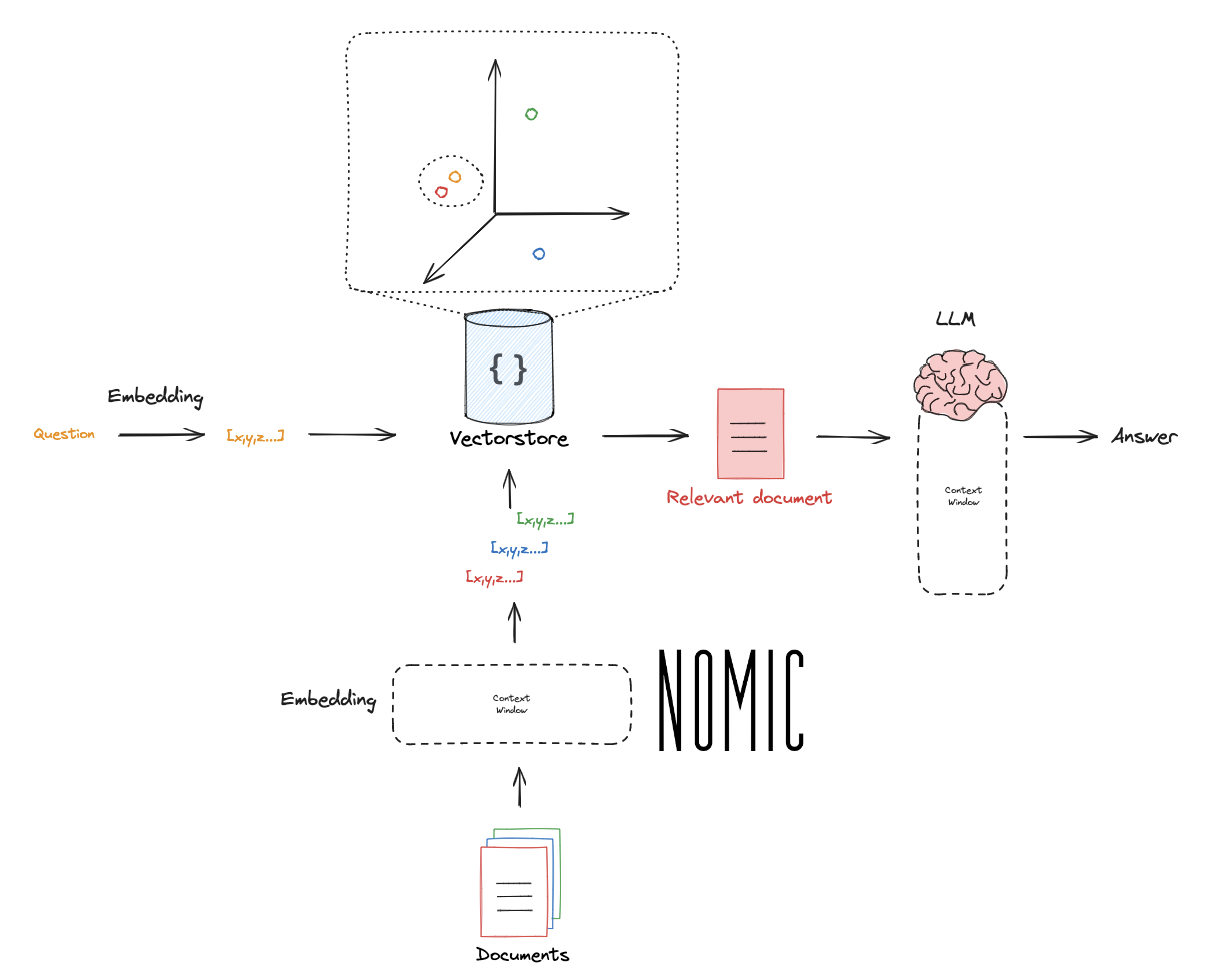

## Signup

Get your API token, then run:
```
! nomic login
```

Then run with your generated API token 
```
! nomic login < token > 
```

In [ ]:
! nomic login

In [1]:
! nomic login token

In [ ]:
! pip install -U langchain-nomic langchain_community tiktoken langchain-openai chromadb langchain

In [ ]:
# Optional: LangSmith API keys
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

## Document Loading

Let's test 3 interesting blog posts.

In [1]:
from langchain_community.document_loaders import WebBaseLoader

urls =["https://lilianweng.github.io/posts/2023-06-23-agent/",
       "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
       "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

## Splitting 

Long context retrieval 

In [2]:
from langchain.text_splitter import CharacterTextSplitter
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=7500, 
                                                            chunk_overlap=100)
doc_splits = text_splitter.split_documents(docs_list)

In [3]:
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
for d in doc_splits:
    print("The document is %s tokens"%len(encoding.encode(d.page_content)))

The document is 6562 tokens
The document is 3037 tokens
The document is 6092 tokens
The document is 1050 tokens
The document is 6933 tokens
The document is 5560 tokens


## Index 

Nomic embeddings [here](https://docs.nomic.ai/reference/endpoints/nomic-embed-text). 

In [4]:
import os
from langchain_nomic import NomicEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

In [5]:
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=NomicEmbeddings(model='nomic-embed-text-v1') 
)
retriever = vectorstore.as_retriever()

## RAG Chain

We can use the Mistral `v0.2`, which is [fine-tuned for 32k context](https://x.com/dchaplot/status/1734198245067243629?s=20).

We can [use Ollama](https://ollama.ai/library/mistral) -
```
ollama pull mistral:instruct
```

We can also run [GPT-4 128k](https://openai.com/blog/new-models-and-developer-products-announced-at-devday). 

In [6]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatOllama

# Prompt 
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# LLM API
model = ChatOpenAI(temperature=0, model="gpt-4-1106-preview")
 
# Local LLM
ollama_llm = "mistral:instruct"
model_local = ChatOllama(model=ollama_llm)

# Chain
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model_local
    | StrOutputParser()
)

In [7]:
# Question
chain.invoke("What are the types of agent memory?")

' Agents, especially those used in artificial intelligence and natural language processing, can have different types of memory. Here are some common types:\n\n1. **Short-term memory** or working memory: This is a small capacity, high-turnover memory that holds information temporarily while the agent processes it. Short-term memory is essential for tasks requiring attention and quick response, such as parsing sentences or following instructions.\n\n2. **Long-term memory**: This is a large capacity, low-turnover memory where agents store information for extended periods. Long-term memory enables learning from experiences, accessing past knowledge, and improving performance over time.\n\n3. **Explicit memory** or declarative memory: Agents use explicit memory to store and recall facts, concepts, and rules that can be expressed in natural language. This type of memory is crucial for problem solving and reasoning.\n\n4. **Implicit memory** or procedural memory: Implicit memory refers to the

**Mistral**

Trace: 24k prompt tokens.

* https://smith.langchain.com/public/3e04d475-ea08-4ee3-ae66-6416a93d8b08/r

--- 

Some considerations are noted in the [needle in a haystack analysis](https://twitter.com/GregKamradt/status/1722386725635580292?lang=en):

* LLMs may suffer with retrieval from large context depending on where the information is placed.